In [1]:
#データとモジュールの読み込み
import numpy as np
import pandas as pd
# 機械学習のライブラリ．今回は線形回帰LinearRegressionを動かす．
# LinearRegressionはsklearnのlinear_modelモジュールの中にあるので，次のようにインポートする
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
# Google Colabの場合
d_train = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2000_2024.csv") # 訓練データを読み込む
d_test = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2025H1_Dst99999.csv") # テストデータを読み込む

Mounted at /content/drive


In [2]:
#指定した列だけ取り出す
xlist = [ 'Year', 'Month', 'Day_of_month','Hour[h]', 'B_mag[nT]','Bx_GSE[nT]', 'By_GSM[nT]','Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]', 'V_sw[km/s]',
         'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num', 'f10.7[sfu]', 'Lyman_alpha[W/m^2]']
         #colabの場合はReturnで改行できる
ylist = ['Dst[nT]']
x_train = d_train[xlist]
y_train = d_train[ylist]
x_test = d_test[xlist]
y_test = d_test[ylist]

In [3]:
x_train.head()

,Year,Month,Day_of_month,Hour[h],B_mag[nT],Bx_GSE[nT],By_GSM[nT],Bz_GSM[nT],T_proton[K],N_proton[cm^-3],V_sw[km/s],Flow_pressure[nPa],E_field[mV/m],Sunspot_num,f10.7[sfu],Lyman_alpha[W/m^2]
0,2000,1,1,0,7.5,-5.6,2.2,1.6,324194.0,2.9,675.0,2.64,-1.08,71,125.6,0.00789
1,2000,1,1,1,7.8,-4.9,4.7,-2.7,302235.0,2.6,677.0,2.38,1.83,71,125.6,0.00789
2,2000,1,1,2,7.6,-2.7,5.3,-1.6,349786.0,2.2,708.0,2.21,1.13,71,125.6,0.00789
3,2000,1,1,3,7.4,-3.9,3.3,-2.3,362297.0,2.1,706.0,2.09,1.62,71,125.6,0.00789
4,2000,1,1,4,7.0,-3.5,1.9,-1.2,429384.0,2.0,721.0,2.08,0.87,71,125.6,0.00789


In [4]:
x_train.columns

Index(['Year', 'Month', 'Day_of_month', 'Hour[h]', 'B_mag[nT]', 'Bx_GSE[nT]',
       'By_GSM[nT]', 'Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]',
       'V_sw[km/s]', 'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num',
       'f10.7[sfu]', 'Lyman_alpha[W/m^2]'],
      dtype='object')

#特定の特徴を強化する

例えば以下のような追加変数を入れてることが考えられます：

・bz（nT） や ey（電場） の変化をより重点的に使う.

・時間的特徴量（例：季節・月・時刻）や移動平均・勾配・履歴値の導入.

In [5]:
#訓練データに新しい特徴量を追加
x_train['Bz_lag6'] = x_train['Bz_GSM[nT]'].shift(6)
x_train['Bz_diff6'] = x_train['Bz_GSM[nT]'] - x_train['Bz_GSM[nT]'].shift(6)
x_train['Bz_ma3'] = x_train['Bz_GSM[nT]'].rolling(3).mean()
x_train['Ef_lag6'] = x_train['E_field[mV/m]'].shift(6)
x_train['Ef_diff6'] = x_train['E_field[mV/m]'] - x_train['E_field[mV/m]'].shift(6)
x_train['Ef_ma3'] = x_train['E_field[mV/m]'].rolling(3).mean()
#テストデータに追加
#Add new feature
x_test['Bz_lag6'] = x_test['Bz_GSM[nT]'].shift(6)
x_test['Bz_diff6'] = x_test['Bz_GSM[nT]'] - x_test['Bz_GSM[nT]'].shift(6)
x_test['Bz_ma3'] = x_test['Bz_GSM[nT]'].rolling(3).mean()
x_test['Ef_lag6'] = x_test['E_field[mV/m]'].shift(6)
x_test['Ef_diff6'] = x_test['E_field[mV/m]'] - x_test['E_field[mV/m]'].shift(6)
x_test['Ef_ma3'] = x_test['E_field[mV/m]'].rolling(3).mean()

In [6]:
x_train.head()

,Year,Month,Day_of_month,Hour[h],B_mag[nT],Bx_GSE[nT],By_GSM[nT],Bz_GSM[nT],T_proton[K],N_proton[cm^-3],...,E_field[mV/m],Sunspot_num,f10.7[sfu],Lyman_alpha[W/m^2],Bz_lag6,Bz_diff6,Bz_ma3,Ef_lag6,Ef_diff6,Ef_ma3
0,2000,1,1,0,7.5,-5.6,2.2,1.6,324194.0,2.9,...,-1.08,71,125.6,0.00789,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,1,1,7.8,-4.9,4.7,-2.7,302235.0,2.6,...,1.83,71,125.6,0.00789,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,1,1,2,7.6,-2.7,5.3,-1.6,349786.0,2.2,...,1.13,71,125.6,0.00789,NaN,NaN,-0.9,NaN,NaN,0.626667
3,2000,1,1,3,7.4,-3.9,3.3,-2.3,362297.0,2.1,...,1.62,71,125.6,0.00789,NaN,NaN,-2.2,NaN,NaN,1.526667
4,2000,1,1,4,7.0,-3.5,1.9,-1.2,429384.0,2.0,...,0.87,71,125.6,0.00789,NaN,NaN,-1.7,NaN,NaN,1.206667


欠損データ(NaN)が出てしまいました.これを取り除く必要がありますが、回答の数が合わなくなるので行を削除してはいけません.そこで一つ後のデータで補完することを考えます.

In [7]:
x_train = x_train.bfill() #ひとつ前のデータで補間
x_test = x_test.bfill()

In [8]:
x_train.head()

,Year,Month,Day_of_month,Hour[h],B_mag[nT],Bx_GSE[nT],By_GSM[nT],Bz_GSM[nT],T_proton[K],N_proton[cm^-3],...,E_field[mV/m],Sunspot_num,f10.7[sfu],Lyman_alpha[W/m^2],Bz_lag6,Bz_diff6,Bz_ma3,Ef_lag6,Ef_diff6,Ef_ma3
0,2000,1,1,0,7.5,-5.6,2.2,1.6,324194.0,2.9,...,-1.08,71,125.6,0.00789,1.6,0.9,-0.9,-1.08,-0.73,0.626667
1,2000,1,1,1,7.8,-4.9,4.7,-2.7,302235.0,2.6,...,1.83,71,125.6,0.00789,1.6,0.9,-0.9,-1.08,-0.73,0.626667
2,2000,1,1,2,7.6,-2.7,5.3,-1.6,349786.0,2.2,...,1.13,71,125.6,0.00789,1.6,0.9,-0.9,-1.08,-0.73,0.626667
3,2000,1,1,3,7.4,-3.9,3.3,-2.3,362297.0,2.1,...,1.62,71,125.6,0.00789,1.6,0.9,-2.2,-1.08,-0.73,1.526667
4,2000,1,1,4,7.0,-3.5,1.9,-1.2,429384.0,2.0,...,0.87,71,125.6,0.00789,1.6,0.9,-1.7,-1.08,-0.73,1.206667


#検証データの作成
詳細は第2回の資料を参照してください．

In [9]:
# 分割前に必ず定義
n_train = len(x_train)
n_valid = int(0.2 * n_train)  # 検証データの数．ラベル付きデータ数n_trainの2割を検証データにする
n_train = n_train - n_valid # 訓練データ数を計算し直す．検証データ以外全てなので，全体（n_train)からn_validationを引く
x_valid = x_train[n_train:] # 現在のX_train_numの後半2割 = 前半8割以降
x_train = x_train[:n_train] # 現在のX_train_numの前半8割．再代入する（変数名を使い回す）

# 目標値も同じように分割する
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

#規則化 (Normalization)
詳しくは前回の資料参照

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

前回と同じようにalphaの値と検証データとモデルのMSEの関係を調べます。 ただしxとyが両方pandasかnumpyにそろえるようにします。今回はx_train_scaledがnumpyになってしまったので、y=y_trainもnumpyにします。

In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

# 候補の alpha
alphas = [1e-4,1e-3, 1e-2, 1e-1, 1, 10, 100,1000,10000,100000,1000000,1e7,1e8]

best_alpha = None
best_rmse = float("inf") #最初無限にする

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True, solver="svd")
    ridge.fit(x_train_scaled, y_train.values)        # 学習(x_trainではなくx_train_scaledになっていることに注意)
    y_pred = ridge.predict(x_valid_scaled)             # テストデータ予測
    rmse = root_mean_squared_error(y_valid, y_pred)   # MSE算出

    print(f"alpha={a}, RMSE={rmse:.3f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a

print("\n最も良い alpha:", best_alpha)
print("そのときの RMSE:", best_rmse)

alpha=0.0001, RMSE=34.449
alpha=0.001, RMSE=34.449
alpha=0.01, RMSE=34.449
alpha=0.1, RMSE=34.449
alpha=1, RMSE=34.450
alpha=10, RMSE=34.457
alpha=100, RMSE=34.513
alpha=1000, RMSE=34.533
alpha=10000, RMSE=32.886
alpha=100000, RMSE=27.900
alpha=1000000, RMSE=20.980
alpha=10000000.0, RMSE=19.690
alpha=100000000.0, RMSE=19.677

最も良い alpha: 100000000.0
そのときの RMSE: 19.677158011793423


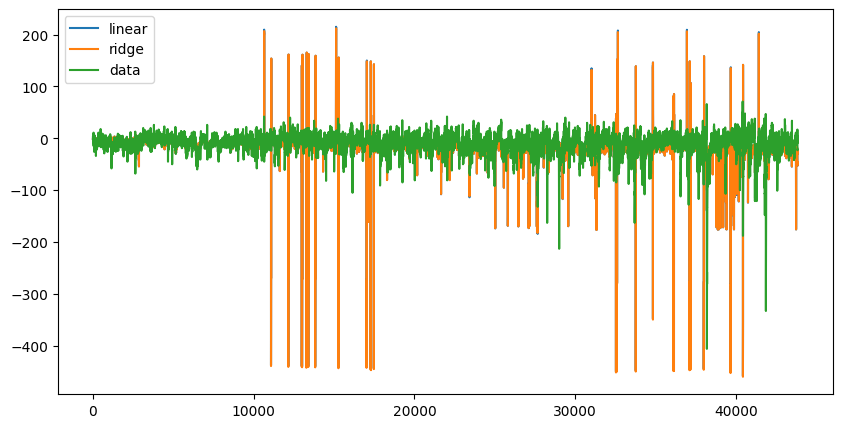

In [12]:
#モジュールの読み込み
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# 通常の線形モデルの作成と予測
lr = LinearRegression()# LinearRegressionのインスタンスの作成
lr.fit(x_train, y_train)# 上で作ったオブジェクトの学習
y_pred_valid_lr = lr.predict(x_valid)#　検証データに対する予測

#Ridge回帰モデルの作成と予測
ridge = Ridge(alpha=100, fit_intercept=True, solver="svd")  # (for version 1.2.2)
ridge.fit(x_train_scaled, y_train.values)
y_pred_valid_rr = ridge.predict(x_valid_scaled)

import matplotlib.pyplot as plt
xplot = np.arange(n_valid) # 0,1,2...n_valid-1のような配列になる
plt.figure(figsize=(10,5)) #figsize => (x,y)の図のサイズ
plt.plot(xplot,y_pred_valid_lr,label="linear") #label; 凡例の文字
plt.plot(xplot,y_pred_valid_rr,label="ridge") #label; 凡例の文字
plt.plot(xplot,y_valid,label="data")
plt.legend() #凡例を表示
plt.show()

In [13]:
#テストデータの予測と提出
y_pred_test = ridge.predict(x_test_scaled)
np.savetxt('/content/drive/My Drive/PBL2025/y_pred_ri2.csv', y_pred_test,delimiter=',')

In [14]:
y_pred_test

array([-38.24449481, -37.70993898, -30.74318719, ..., -16.2485144 ,
       -16.65122601, -17.52191445])